In [1]:
# CSS style setting
!wget http://bit.ly/3ZLyF82 -O CSS.css -q
    
from IPython.core.display import HTML
with open('./CSS.css', 'r') as file:
    custom_css = file.read()

HTML(custom_css)

## Import Toolkits

In [18]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report , confusion_matrix

import os
import itertools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Activation , Dropout , BatchNormalization
from tensorflow.keras.optimizers import Adam , Adamax

import warnings 
warnings.filterwarnings('ignore')

# Data Preprocessing

## Prepare Data

In [3]:
data_path = '/kaggle/input/shoe-vs-sandal-vs-boot-dataset-15k-images/Shoe vs Sandal vs Boot Dataset'
filepath = []
labels = []

folds = os.listdir(data_path)

for fold in folds:
    foldpath = os.path.join(data_path , fold)
    files = os.listdir(foldpath)
    
    for file in files :
        
        file_path = os.path.join(foldpath , file)
        filepath.append(file_path)
        labels.append(fold)
        
#concat data path with labels

fseries = pd.Series(filepath , name= 'filepath')
lseries = pd.Series(labels , name = 'labels')

df = pd.concat([fseries , lseries] , axis = 1)

df

,filepath,labels
0,/kaggle/input/shoe-vs-sandal-vs-boot-dataset-1...,Shoe
1,/kaggle/input/shoe-vs-sandal-vs-boot-dataset-1...,Shoe
2,/kaggle/input/shoe-vs-sandal-vs-boot-dataset-1...,Shoe
3,/kaggle/input/shoe-vs-sandal-vs-boot-dataset-1...,Shoe
4,/kaggle/input/shoe-vs-sandal-vs-boot-dataset-1...,Shoe
...,...,...
14995,/kaggle/input/shoe-vs-sandal-vs-boot-dataset-1...,Boot
14996,/kaggle/input/shoe-vs-sandal-vs-boot-dataset-1...,Boot
14997,/kaggle/input/shoe-vs-sandal-vs-boot-dataset-1...,Boot
14998,/kaggle/input/shoe-vs-sandal-vs-boot-dataset-1...,Boot


## Data Spliting

In [4]:
train , dummy = train_test_split(df , train_size = 0.8 , shuffle = True , random_state = 42)
valid , test = train_test_split(df , test_size = 0.5 , shuffle = True , random_state = 42)
print("Train Shape",train.shape)
print("Valid Shape",valid.shape)
print("Test Shape",test.shape)

Train Shape (12000, 2)
Valid Shape (7500, 2)
Test Shape (7500, 2)


## Image Data Generator

In [5]:
img_size = (224 , 224)
batches = 32 


tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train , x_col = 'filepath',y_col = "labels" , target_size = img_size ,color_mode = 'rgb',
                                       class_mode = 'categorical', shuffle = True , batch_size = batches)

test_gen = ts_gen.flow_from_dataframe(test , x_col = 'filepath' , y_col= 'labels' , target_size = img_size , color_mode= 'rgb',
                                     class_mode = 'categorical' , shuffle = False , batch_size = batches)

val_gen = ts_gen.flow_from_dataframe(valid , x_col = 'filepath' , y_col= 'labels',target_size = img_size ,color_mode = 'rgb',
                                    class_mode = 'categorical', shuffle = True , batch_size = batches)

Found 12000 validated image filenames belonging to 3 classes.
Found 7500 validated image filenames belonging to 3 classes.
Found 7500 validated image filenames belonging to 3 classes.


# Show Sample From Train Data

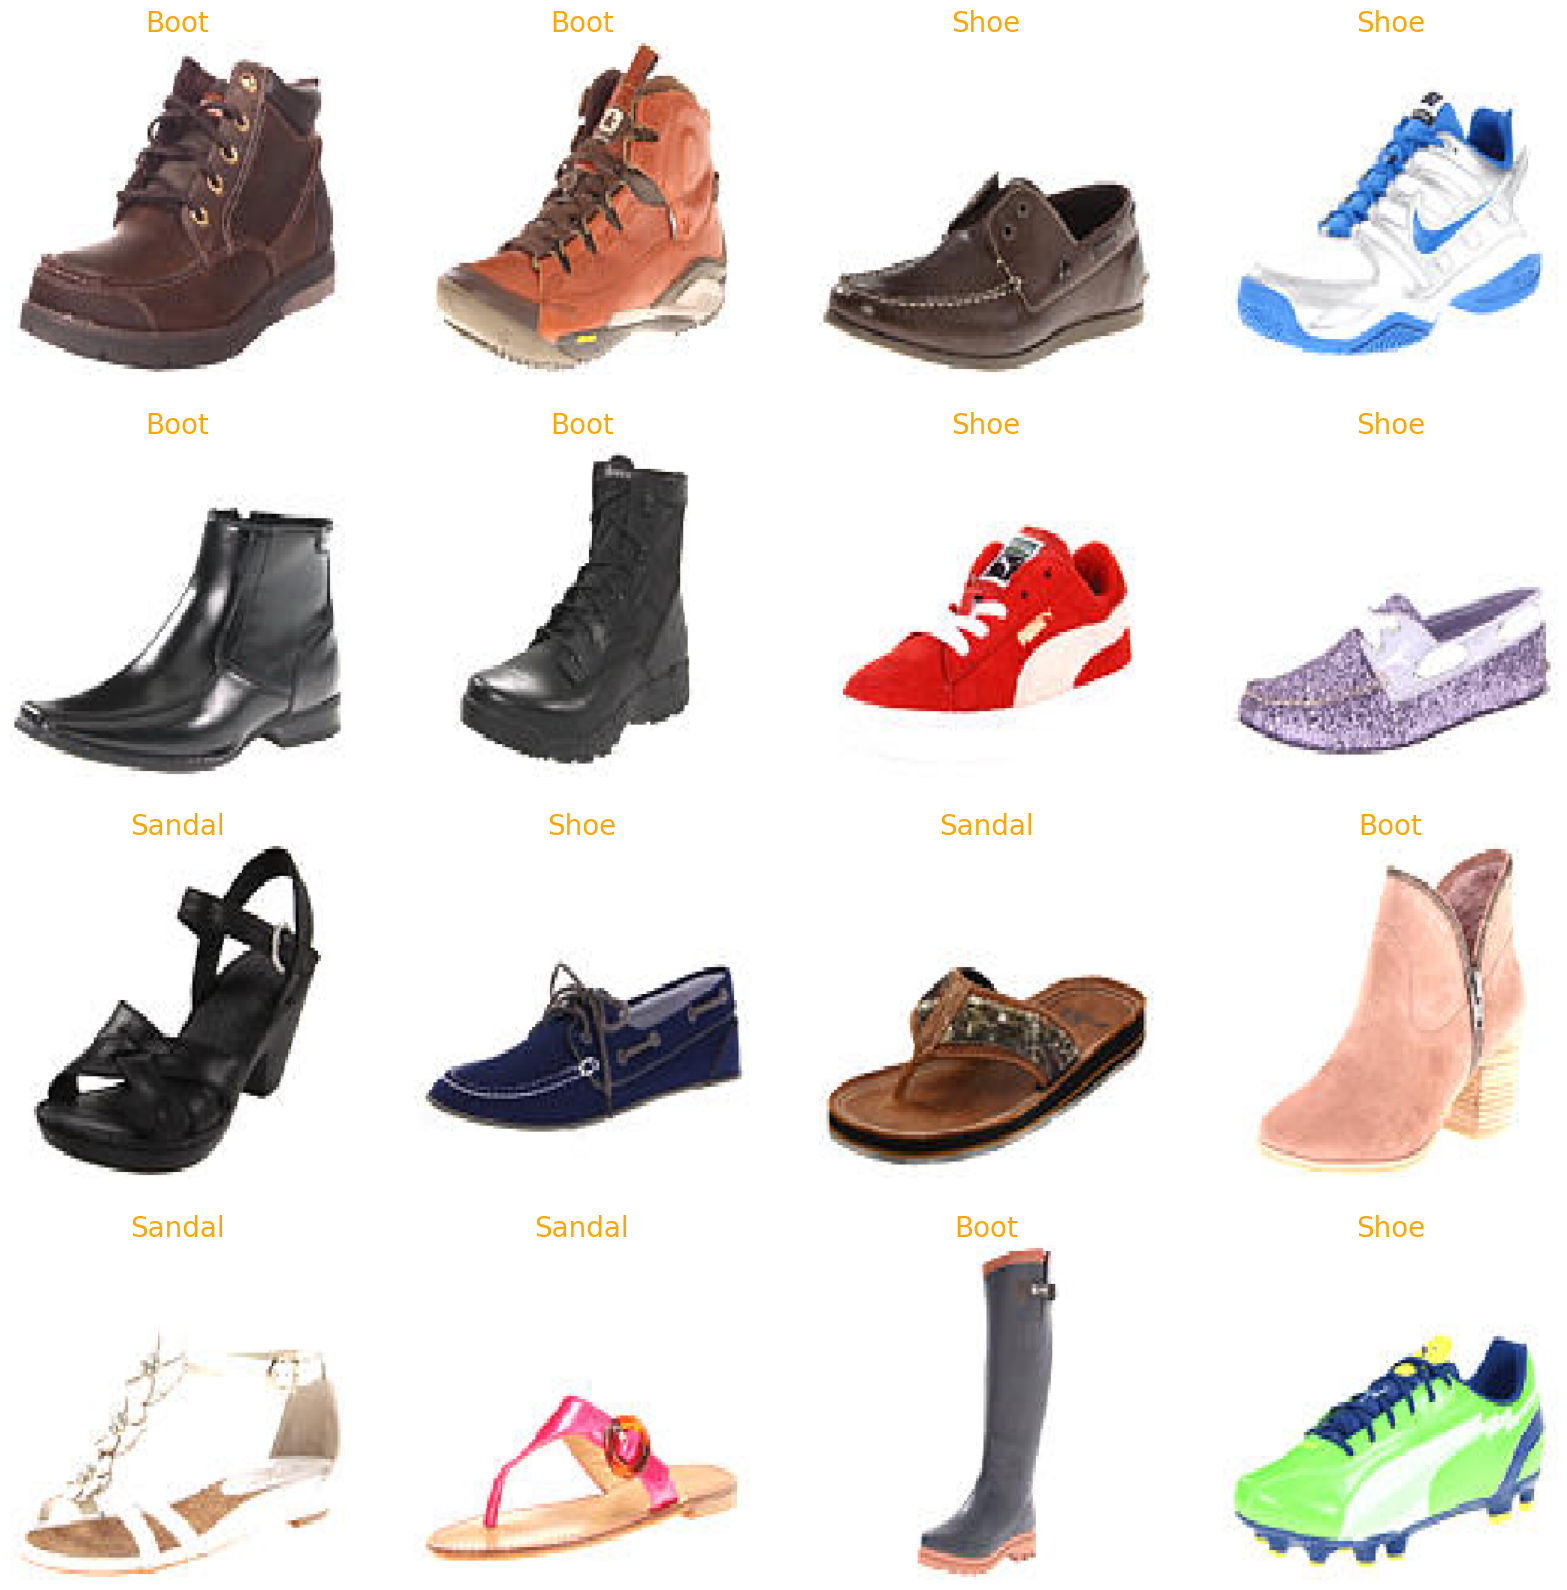

In [6]:
dict_gen = train_gen.class_indices
classes = list(dict_gen.keys())

images , labels = next(train_gen)

plt.figure(figsize = (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'orange', fontsize = 20)
    plt.axis('off')
    
plt.show();

## Model Structure

In [7]:
channels = 3
img_shape = (img_size[0] , img_size[1] , channels)
class_count = len(classes)

base_model = tf.keras.applications.ConvNeXtSmall(include_top = False , weights = 'imagenet' ,pooling = 'max',
                                                     input_shape= img_shape )

for layer in base_model.layers:
    layer.trainable = False
    
model = Sequential([
    base_model,
    BatchNormalization(axis = -1,momentum=0.99,epsilon=0.001),
    Dense(256 , activation= 'relu'),
    Dense(class_count , activation = 'softmax')
])

model.compile(Adamax(learning_rate = 0.001) , loss= 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

198551472/198551472 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ convnext_small (Functional)     │ ?                      │    49,454,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,454,688 (188.65 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 49,454,688 (188.65 MB)

## Iterate

In [8]:
epochs = 10
his = model.fit(x= train_gen , validation_data= val_gen , epochs = epochs , validation_steps= None ,verbose= 1,
               shuffle = False)

Epoch 1/10
  1/375 ━━━━━━━━━━━━━━━━━━━━ 2:35:26 25s/step - accuracy: 0.2812 - loss: 1.4705

I0000 00:00:1720542811.093166    1412 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1720542811.141433    1412 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720542811.141738    1412 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720542811.142141    1412 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720542811.143126    1412 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720542811.143501    1412 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720542811.143861    1412 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720542811.144241    1412 graph_launch.cc:671] Fallback to op-by-op mode because m

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9348 - loss: 0.1723

W0000 00:00:1720542865.723894    1411 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720542865.724220    1411 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720542865.724646    1411 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720542865.725577    1411 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720542865.725903    1411 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720542865.726226    1411 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720542865.726542    1411 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720542865.726842    1411 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


375/375 ━━━━━━━━━━━━━━━━━━━━ 113s 236ms/step - accuracy: 0.9349 - loss: 0.1722 - val_accuracy: 0.9891 - val_loss: 0.0414
Epoch 2/10


W0000 00:00:1720542899.545218    1412 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720542899.545628    1412 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720542899.546129    1412 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


375/375 ━━━━━━━━━━━━━━━━━━━━ 77s 206ms/step - accuracy: 0.9819 - loss: 0.0551 - val_accuracy: 0.9940 - val_loss: 0.0239
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 77s 206ms/step - accuracy: 0.9867 - loss: 0.0412 - val_accuracy: 0.9975 - val_loss: 0.0149
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 77s 206ms/step - accuracy: 0.9924 - loss: 0.0276 - val_accuracy: 0.9984 - val_loss: 0.0101
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 77s 206ms/step - accuracy: 0.9967 - loss: 0.0165 - val_accuracy: 0.9989 - val_loss: 0.0060
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 77s 206ms/step - accuracy: 0.9965 - loss: 0.0167 - val_accuracy: 0.9999 - val_loss: 0.0039
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 77s 206ms/step - accuracy: 0.9985 - loss: 0.0092 - val_accuracy: 0.9997 - val_loss: 0.0029
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 77s 206ms/step - accuracy: 0.9987 - loss: 0.0091 - val_accuracy: 0.9997 - val_loss: 0.0020
Epoch 9/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 77s 206ms/step - accuracy: 0.9979 - loss: 0.0074 - val

# Model Performance

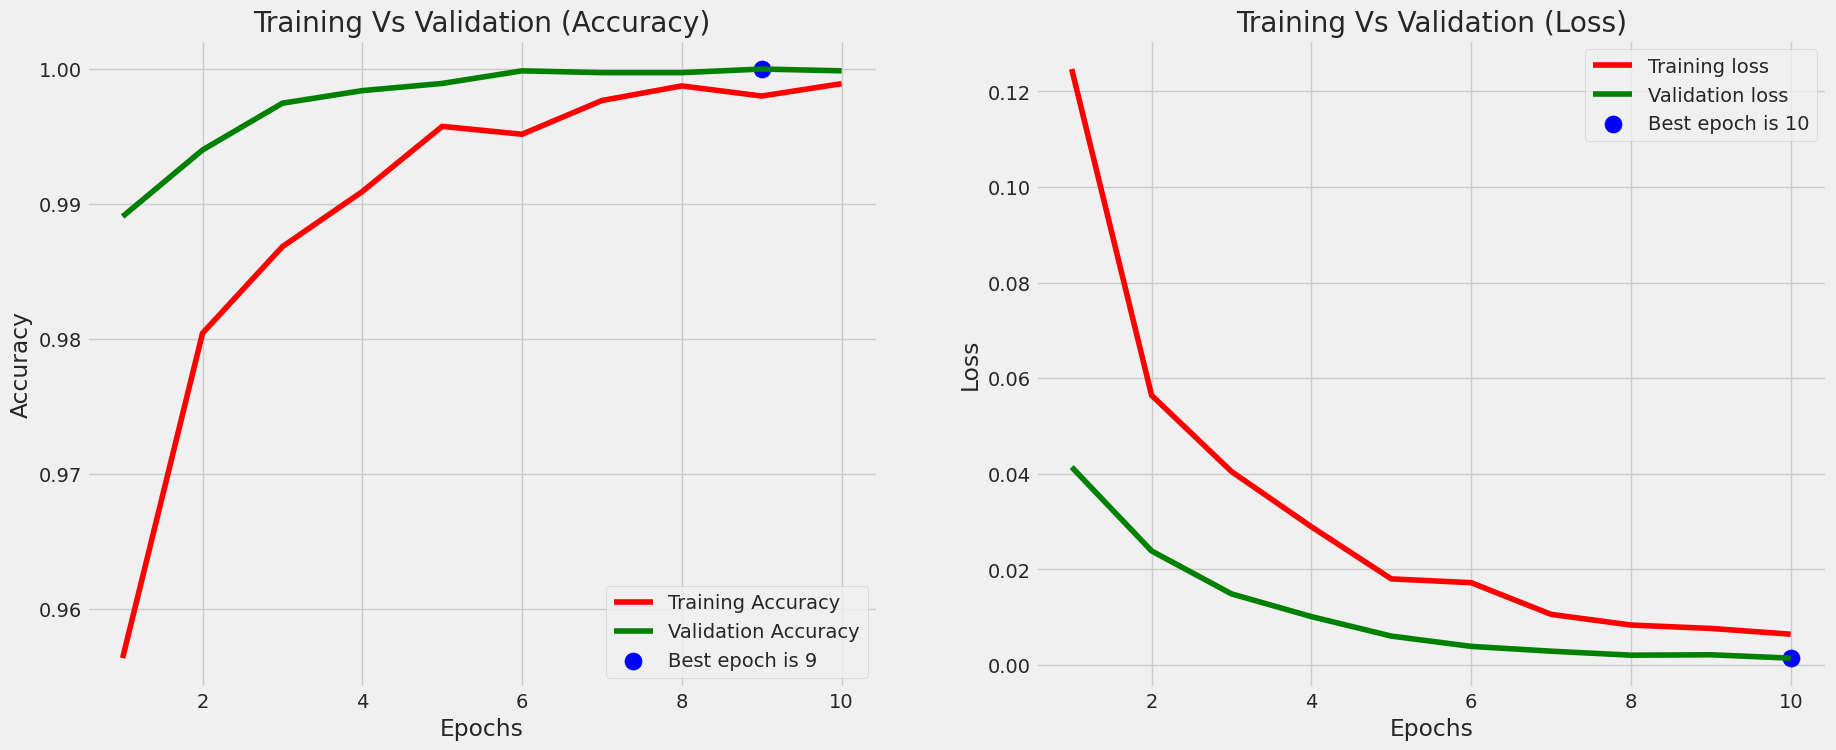

In [12]:
train_acc = his.history['accuracy']
train_loss = his.history['loss']

val_acc = his.history['val_accuracy']
val_loss = his.history['val_loss']

index_loss = np.argmin(val_loss)
index_acc = np.argmax(val_acc)

val_lowest = val_loss[index_loss]
val_highest = val_acc[index_acc]

epochs = [i+1 for i in range(len(train_acc))]
acc_label = f'Best epoch is {str(index_acc +1)}'
loss_label = f'Best epoch is {str(index_loss +1)}'

plt.figure(figsize = (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(epochs , train_acc , 'r' , label= 'Training Accuracy')
plt.plot(epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc+1 , val_highest , s = 150 , c = 'blue' , label = acc_label)
plt.title("Training Vs Validation (Accuracy)")
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs , train_loss , 'r' , label = "Training loss")
plt.plot(epochs , val_loss , 'g' , label = 'Validation loss')
plt.scatter(index_loss+1 , val_lowest , s = 150 , c= 'blue' , label = loss_label)
plt.title("Training Vs Validation (Loss)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout
plt.show();

# Model Evaluation

In [13]:
train_score = model.evaluate(train_gen , steps = 32 , verbose = 1)
valid_score = model.evaluate(val_gen , steps = 32 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 32 , verbose = 1)

print(f'Train Loss {train_score[0]} and Train Accuracy {train_score[1]}')
print(f'Validation Loss {valid_score[0]} and Validation Accuracy {valid_score[1]}')
print(f'Test Loss {test_score[0]} Test Accuracy {test_score[1]}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 0.0015
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 0.0011
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 276ms/step - accuracy: 0.9844 - loss: 0.0591
Train Loss 0.001161733060143888 and Train Accuracy 1.0
Validation Loss 0.0010140548693016171 and Validation Accuracy 1.0
Test Loss 0.07202549278736115 Test Accuracy 0.9833984375


# Model Prediction

## Confusion Matrix

In [14]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds , axis = 1)

  2/235 ━━━━━━━━━━━━━━━━━━━━ 28s 123ms/step

W0000 00:00:1720544119.607264    1411 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720544119.607579    1411 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720544119.607998    1411 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720544119.608931    1411 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720544119.609272    1411 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720544119.609601    1411 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720544119.609937    1411 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720544119.610278    1411 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


235/235 ━━━━━━━━━━━━━━━━━━━━ 49s 181ms/step


W0000 00:00:1720544162.015998    1414 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720544162.016319    1414 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720544162.016712    1414 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


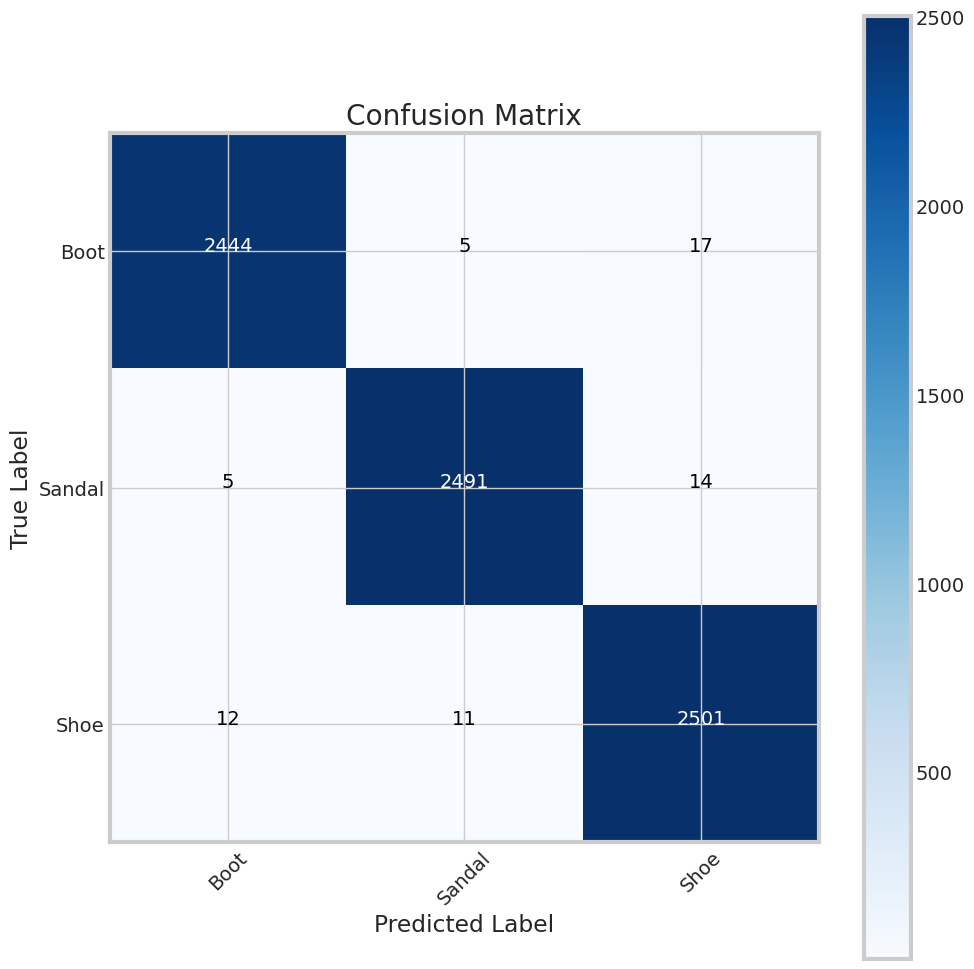

In [19]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

## Classification Report

In [17]:
print(classification_report(test_gen.classes , y_pred , target_names = classes))

              precision    recall  f1-score   support

        Boot       0.99      0.99      0.99      2466
      Sandal       0.99      0.99      0.99      2510
        Shoe       0.99      0.99      0.99      2524

    accuracy                           0.99      7500
   macro avg       0.99      0.99      0.99      7500
weighted avg       0.99      0.99      0.99      7500

